In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline 
#!pip install mpld3
import mpld3
mpld3.enable_notebook()

from scipy.integrate import odeint
#!pip install lmfit
import lmfit
from lmfit.lineshapes import gaussian, lorentzian

import warnings
warnings.filterwarnings('ignore')
from PIL import Image

## Script - Supplemental and Coronavirus Data

In [2]:
# !! if you get a timeout-error, just click on the link and download the data manually !!

# read the data
beds = pd.read_csv("beds.csv", header=0)
agegroups = pd.read_csv("agegroups.csv")
probabilities = pd.read_csv("probabilities.csv")
covid_data = pd.read_csv('time_series_covid19_deaths_global_narrow.csv', parse_dates=["Date"], skiprows=[1])
covid_data["Location"] = covid_data["Country/Region"]

# create some dicts for fast lookup
# 1. beds
beds_lookup = dict(zip(beds["Country"], beds["ICU_Beds"]))
# 2. agegroups
agegroup_lookup = dict(zip(agegroups['Location'], agegroups[['0_9', '10_19', '20_29', '30_39', '40_49', '50_59', '60_69', '70_79', '80_89', '90_100']].values))

# store the probabilities collected
prob_I_to_C_1 = list(probabilities.prob_I_to_ICU_1.values)
prob_I_to_C_2 = list(probabilities.prob_I_to_ICU_2.values)
prob_C_to_Death_1 = list(probabilities.prob_ICU_to_Death_1.values)
prob_C_to_Death_2 = list(probabilities.prob_ICU_to_Death_2.values)

## Function - Plotter

In [3]:
plt.gcf().subplots_adjust(bottom=0.15)

def plotter(region,t, S, E, I, C, R, D, R_0, B, S_1=None, S_2=None, x_ticks=None):
    if S_1 is not None and S_2 is not None:
      print(f"percentage going to ICU: {S_1*100}; percentage dying in ICU: {S_2 * 100}")


    f, ax = plt.subplots(1,1,figsize=(15,3))
    if x_ticks is None:
        ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(t, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    else:
        ax.plot(x_ticks, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(x_ticks, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(x_ticks, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(x_ticks, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.plot(x_ticks, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(x_ticks, D, 'k', alpha=0.7, linewidth=2, label='Dead')

        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()


    ax.title.set_text('extended SEIR-Model')

    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    f.savefig(region+' figure 2.png')
    plt.show();

    f = plt.figure(figsize=(15,3))
    # sp1
    ax1 = f.add_subplot(131)
    if x_ticks is None:
        ax1.plot(t, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
    else:
        ax1.plot(x_ticks, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
        ax1.xaxis.set_major_locator(mdates.YearLocator())
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax1.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

 
    ax1.title.set_text('R_0 over time')
    ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    
    # sp2
    ax2 = f.add_subplot(132)
    total_CFR = [0] + [100 * D[i] / sum(sigma*E[:i]) if sum(sigma*E[:i])>0 else 0 for i in range(1, len(t))]
    daily_CFR = [0] + [100 * ((D[i]-D[i-1]) / ((R[i]-R[i-1]) + (D[i]-D[i-1]))) if max((R[i]-R[i-1]), (D[i]-D[i-1]))>10 else 0 for i in range(1, len(t))]
    if x_ticks is None:
        ax2.plot(t, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(t, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
    else:
        ax2.plot(x_ticks, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(x_ticks, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
        ax2.xaxis.set_major_locator(mdates.YearLocator())
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax2.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

    ax2.title.set_text('Fatality Rate (%)')
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    # sp3
    ax3 = f.add_subplot(133)
    newDs = [0] + [D[i]-D[i-1] for i in range(1, len(t))]
    if x_ticks is None:
        ax3.plot(t, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(t, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
    else:
        ax3.plot(x_ticks, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(x_ticks, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
        ax3.xaxis.set_major_locator(mdates.YearLocator())
        ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax3.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

    ax3.title.set_text('Deaths per day')
    ax3.yaxis.set_tick_params(length=0)
    ax3.xaxis.set_tick_params(length=0)
    ax3.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax3.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.savefig(region+' figure 3.png')
    plt.show();

<Figure size 432x288 with 0 Axes>

## Function - Baseline Model

In [4]:
def deriv(y, t, beta, gamma, sigma, N, eta, alpha, Beds):
    S, E, I, C, R, D = y

    dSdt = -beta(t) * I * S / N
    dEdt = beta(t) * I * S / N - sigma * E
    dIdt = sigma * E - 1/12.0 * eta * I - gamma * (1 - eta) * I
    dCdt = 1/12.0 * eta * I - 1/7.5 * alpha * min(Beds(t), C) - max(0, C-Beds(t)) - (1 - alpha) * 1/6.5 * min(Beds(t), C)
    dRdt = gamma * (1 - eta) * I + (1 - alpha) * 1/6.5 * min(Beds(t), C)
    dDdt = 1/7.5 * alpha * min(Beds(t), C) + max(0, C-Beds(t))
    return dSdt, dEdt, dIdt, dCdt, dRdt, dDdt

In [5]:
gamma = 1.0/9.0
sigma = 1.0/3.0

def logistic_R_0(t, R_0_start, k, x0, R_0_end):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

def Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s):

    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma

    N = sum(agegroups)
    
    def Beds(t):
        beds_0 = beds_per_100k / 100_000 * N
        return beds_0 + s*beds_0*t  # 0.003

    y0 = N-1.0, 1.0, 0.0, 0.0, 0.0, 0.0
    t = np.linspace(0, days-1, days)
    ret = odeint(deriv, y0, t, args=(beta, gamma, sigma, N, prob_I_to_C, prob_C_to_D, Beds))
    S, E, I, C, R, D = ret.T
    R_0_over_time = [beta(i)/gamma for i in range(len(t))]

    return t, S, E, I, C, R, D, R_0_over_time, Beds, prob_I_to_C, prob_C_to_D

## Function - Fitting

In [6]:
def fitting_by_region(region):
    if region == 'UK':
        data = UK_data['cumDeaths28DaysByDeathDate'].to_list()[::-1][0:60]
    else:
        data = England_data[England_data.areaName == region]['cumDeaths28DaysByDeathDate'].to_list()[::-1][0:60]
    agegroups = agegroup_lookup["United Kingdom"]
    beds_per_100k = beds_lookup["United Kingdom"]
    
    params_init_min_max = {"R_0_start": (3.0, 2.0, 8.0), "k": (2.5, 0.01, 5.0), "x0": (90, 0, 120), "R_0_end": (0.9, 0.3, 3.5),
                           "prob_I_to_C": (0.05, 0.01, 0.1), "prob_C_to_D": (0.5, 0.05, 0.8),
                           "s": (0.003, 0.001, 0.01)}  # form: {parameter: (initial guess, minimum value, max value)}
    days = outbreak_shift + len(data)
    if outbreak_shift >= 0:
        y_data = np.concatenate((np.zeros(outbreak_shift), data))
    else:
        y_data = y_data[-outbreak_shift:]

    x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array

    def fitter(x, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s):
        ret = Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s)
        return ret[6][x]
    
    mod = lmfit.Model(fitter)

    for kwarg, (init, mini, maxi) in params_init_min_max.items():
        mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

    params = mod.make_params()
    fit_method = 'leastsq'
    result = mod.fit(y_data, params, method="least_squares", x=x_data)
    print(result.best_values)
    return result

## Function - Plot Result 

In [7]:
def plot_result(region): 
    result = fitting_by_region(region)

    result.plot_fit(datafmt="-");
    plt.title(region)
    
    plt.plot(range(10))
    plt.savefig(region+' figure 1.png')
    
    full_days = 60
    first_date = np.datetime64(covid_data.Date.min()) - np.timedelta64(outbreak_shift,'D')
    x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
    print("Prediction for " + region)
    plotter(region,*Model(full_days, agegroup_lookup["United Kingdom"], beds_lookup["United Kingdom"], **result.best_values), x_ticks=x_ticks);

## Script - Print 

{'R_0_start': 7.757258902281658, 'k': 0.5501723451504342, 'x0': 41.83785721488661, 'R_0_end': 0.30000000000000004, 'prob_I_to_C': 0.040964764143647275, 'prob_C_to_D': 0.21611318333604157, 's': 0.009999956081260971}
Prediction for London
percentage going to ICU: 4.096476414364727; percentage dying in ICU: 21.611318333604157


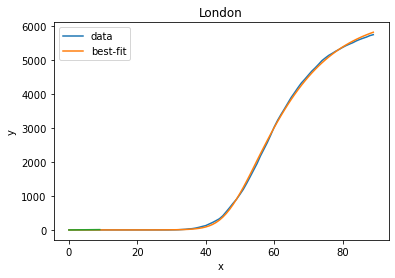

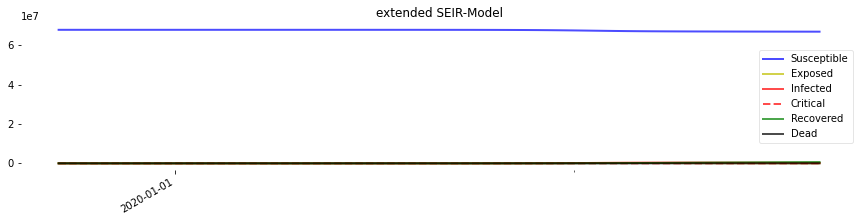

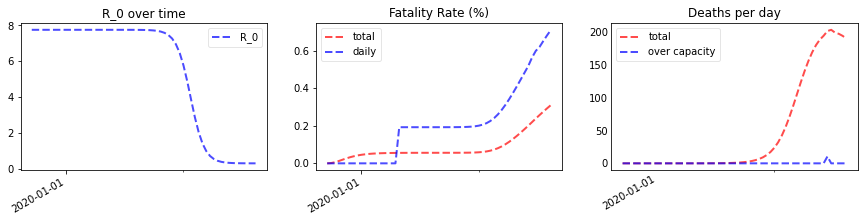

In [9]:
England_data = pd.read_csv('England_Cumdeath_by_Region.csv')
outbreak_shift = 30
plot_result('London')

{'R_0_start': 5.477935168350583, 'k': 2.4190452213590583, 'x0': 51.79477506260841, 'R_0_end': 0.8371372125983966, 'prob_I_to_C': 0.09407481290015005, 'prob_C_to_D': 0.7935504531071241, 's': 0.005424080910357749}
Prediction for UK
percentage going to ICU: 9.407481290015005; percentage dying in ICU: 79.35504531071241


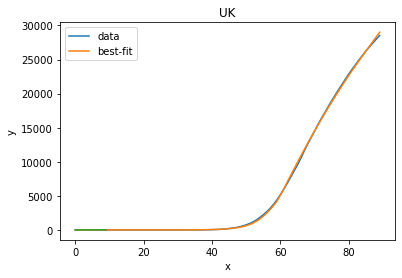

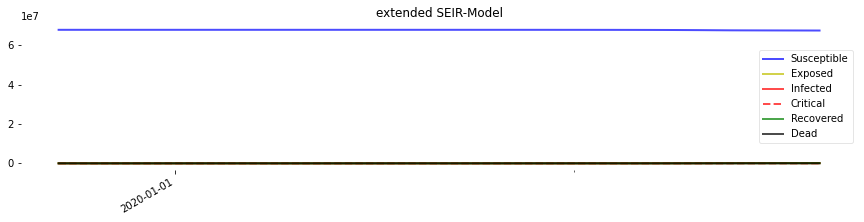

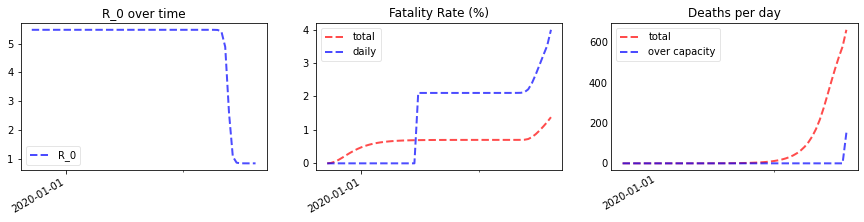

In [10]:
UK_data = pd.read_csv('UK_Data.csv')
plot_result('UK')

In [ ]:
for region in England_data['areaName'].unique():
    plot_result(region)

## Function - Adjusted Model (Mask)

In [11]:
def deriv_adjust(y, t, beta, gamma, sigma, N, eta, alpha, Beds):
    S_W, E_W, I_W, C_W, R_W, D_W,S_NW,E_NW,I_NW,C_NW,R_NW,D_NW = y

    dS_Wdt = -beta(t) * I_W * S_W / N - beta(t) * (1-epsilon_out) * I_NW * S_W / N
    dE_Wdt = beta(t) * I_W * S_W / N + beta(t) * (1-epsilon_out) * I_NW * S_W / N - sigma * E_W
    dI_Wdt = sigma * E_W - 1/12.0 * eta * I_W - gamma * (1 - eta) * I_W
    dC_Wdt = 1/12.0 * eta * I_W - 1/7.5 * alpha * min(Beds(t), C_W) - max(0, C_W-Beds(t)) - (1 - alpha) * 1/6.5 * min(Beds(t), C_W)
    dR_Wdt = gamma * (1 - eta) * I_W + (1 - alpha) * 1/6.5 * min(Beds(t), C_W)
    dD_Wdt = 1/7.5 * alpha * min(Beds(t), C_W) + max(0, C_W-Beds(t))

    dS_NWdt = -beta(t) *(1-epsilon_in)* I_W * S_NW / N - beta(t) * (1-epsilon_in)*(1-epsilon_out) * I_NW * S_NW / N
    dE_NWdt = beta(t) *(1-epsilon_in)* I_W * S_NW / N + beta(t) * (1-epsilon_in)*(1-epsilon_out) * I_NW * S_NW / N - sigma * E_NW
    dI_NWdt = sigma * E_NW - 1/12.0 * eta * I_NW - gamma * (1 - eta) * I_NW
    dC_NWdt = 1/12.0 * eta * I_NW - 1/7.5 * alpha * min(Beds(t), C_NW) - max(0, C_NW-Beds(t)) - (1 - alpha) * 1/6.5 * min(Beds(t), C_NW)
    dR_NWdt = gamma * (1 - eta) * I_NW + (1 - alpha) * 1/6.5 * min(Beds(t), C_NW)
    dD_NWdt = 1/7.5 * alpha * min(Beds(t), C_NW) + max(0, C_NW-Beds(t))
    return dS_Wdt,dE_Wdt,dI_Wdt,dC_Wdt,dR_Wdt,dD_Wdt,dS_NWdt,dE_NWdt,dI_NWdt,dC_NWdt,dR_NWdt,dD_NWdt

In [12]:
gamma = 1.0/9.0
sigma = 1.0/3.0
epsilon_out = 0.5
epsilon_in = 0.5
def logistic_R_0(t, R_0_start, k, x0, R_0_end):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

def Model_Adjusted(pi,days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s):

    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma

    N = sum(agegroups)
    
    def Beds(t):
        beds_0 = beds_per_100k / 100_000 * N
        return beds_0 + s*beds_0*t  # 0.003

    y0 = (N-10)*(1-pi), 10, 0, 0, 0, 0,(N-1)*pi,0,0,0,0,0
    t = np.linspace(0, days-1, days)
    ret = odeint(deriv_adjust, y0, t, args=(beta, gamma, sigma, N, prob_I_to_C, prob_C_to_D, Beds))
    S_W, E_W, I_W, C_W, R_W, D_W,S_NW,E_NW,I_NW,C_NW,R_NW,D_NW = ret.T
    R_0_over_time = [beta(i)/gamma for i in range(len(t))]

    return t, S_W, E_W, I_W, C_W, R_W, D_W,S_NW,E_NW,I_NW,C_NW,R_NW,D_NW, R_0_over_time, Beds, prob_I_to_C, prob_C_to_D

## Script - Predicting Death Under Different Coverage

In [13]:
result = fitting_by_region('UK')

{'R_0_start': 5.477935168350583, 'k': 2.4190452213590583, 'x0': 51.79477506260841, 'R_0_end': 0.8371372125983966, 'prob_I_to_C': 0.09407481290015005, 'prob_C_to_D': 0.7935504531071241, 's': 0.005424080910357749}


In [14]:
x_30 = Model_Adjusted(0.3,150, agegroup_lookup["United Kingdom"], beds_lookup["United Kingdom"], **result.best_values)
x_50 = Model_Adjusted(0.5,150, agegroup_lookup["United Kingdom"], beds_lookup["United Kingdom"], **result.best_values)
x_70 = Model_Adjusted(0.7,150, agegroup_lookup["United Kingdom"], beds_lookup["United Kingdom"], **result.best_values)

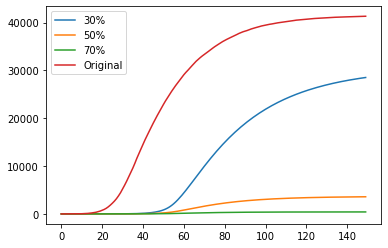

In [15]:
plt.plot(x_30[6]+x_30[12],label = '30%')
plt.plot(x_50[6]+x_50[12],label = '50%')
plt.plot(x_70[6]+x_70[12],label = '70%')
plt.plot(UK_data['cumDeaths28DaysByDeathDate'].to_list()[::-1][0:150],label='Original')
plt.legend()

### Function Fitting Adjust Model

In [20]:
len(recent_data)

478

{'R_0_start': 7.757258902281658, 'k': 0.5501723451504342, 'x0': 41.83785721488661, 'R_0_end': 0.30000000000000004, 'prob_I_to_C': 0.040964764143647275, 'prob_C_to_D': 0.21611318333604157, 's': 0.009999956081260971}
Prediction for London
percentage going to ICU: 4.096476414364727; percentage dying in ICU: 21.611318333604157


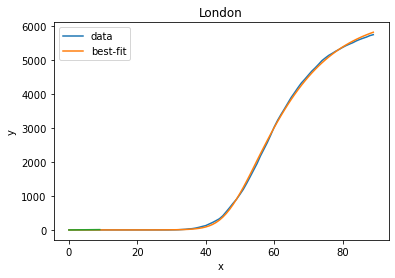

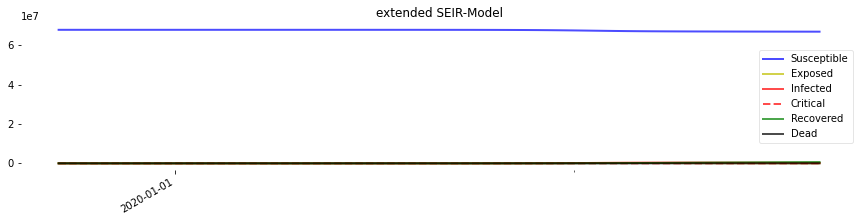

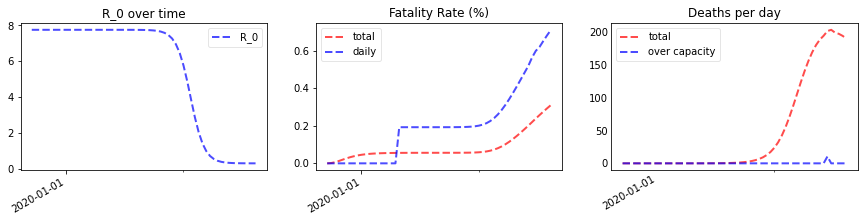

In [22]:
England_data = pd.read_csv('England_Cumdeath_by_Region.csv')
outbreak_shift = 30
plot_result('London')

In [23]:
def fitting_by_region_recent(region):
    if region == 'UK':
        data = UK_data['cumDeaths28DaysByDeathDate'].to_list()[::-1][-60:]
    else:
        data = England_data[England_data.areaName == region]['cumDeaths28DaysByDeathDate'].to_list()[::-1][-60:]
    agegroups = agegroup_lookup["United Kingdom"]
    beds_per_100k = beds_lookup["United Kingdom"]
    
    params_init_min_max = {"R_0_start": (3.0, 2.0, 8.0), "k": (2.5, 0.01, 5.0), "x0": (90, 0, 120), "R_0_end": (0.9, 0.3, 3.5),
                           "prob_I_to_C": (0.05, 0.01, 0.1), "prob_C_to_D": (0.5, 0.05, 0.8),
                           "s": (0.003, 0.001, 0.01)}  # form: {parameter: (initial guess, minimum value, max value)}
    days = outbreak_shift + len(data)
    if outbreak_shift >= 0:
        y_data = np.concatenate((np.zeros(outbreak_shift), data))
    else:
        y_data = y_data[-outbreak_shift:]

    x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array

    def fitter(x, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s):
        ret = Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s)
        return ret[6][x]
    
    mod = lmfit.Model(fitter)

    for kwarg, (init, mini, maxi) in params_init_min_max.items():
        mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

    params = mod.make_params()
    fit_method = 'leastsq'
    result = mod.fit(y_data, params, method="least_squares", x=x_data)
    print(result.best_values)
    return result